In [1]:
include("BayesianUtilities/BayesianUtilities.jl")
using Plots, LinearAlgebra, Distributions, Random, ForwardDiff, DelimitedFiles, DataFrames, .BayesianUtilities

In [2]:
# True unknown position update matrix for the moving object
Random.seed!(1)
M = [1. -0.4; 0.3 0.8]
eigen(M)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
eigenvalues:
2-element Array{Complex{Float64},1}:
 0.8999999999999999 + 0.33166247903553997im
 0.8999999999999999 - 0.33166247903553997im
eigenvectors:
2×2 Array{Complex{Float64},2}:
 0.755929+0.0im       0.755929-0.0im     
 0.188982-0.626783im  0.188982+0.626783im

In [3]:
T = 15
position = 3*ones(2,T)

for t=2:T
    position[:,t] = M*position[:,t-1]
end

In [4]:
# sensor locations
sensor1 = [5.,5.]
sensor2 = [-2.,0.]
sensor3 = [0.,15.]
;

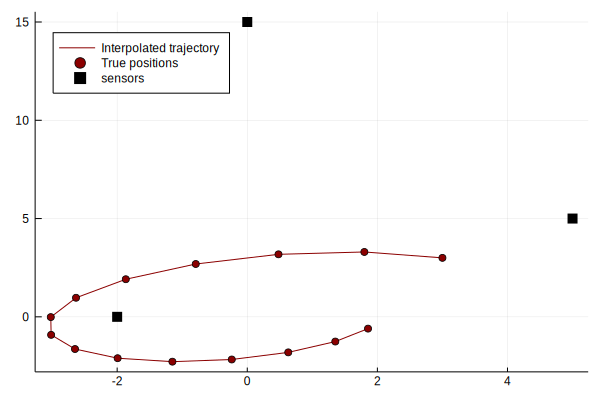

In [5]:
# Visualization of sensors and true discrete positions of the moving object
plot(position[1,:],position[2,:],color=:redsblues,legend=:topleft, label="Interpolated trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="True positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")

In [6]:
observation = zeros(3,T)

disturbance1 = Normal(0,sqrt(0.2))
disturbance2 = Normal(0,sqrt(0.25))
disturbance3 = Normal(0,sqrt(0.2))

for t=1:T
    o1 = sqrt(sum((position[:,t]-sensor1).^2)) + rand(disturbance1)
    o2 = sqrt(sum((position[:,t]-sensor2).^2)) + rand(disturbance2)
    o3 = sqrt(sum((position[:,t]-sensor3).^2)) + rand(disturbance3)
    obs = [o1,o2,o3]
    observation[:,t] = obs
end

# Model Specification

In [7]:
# Newtonian dynamics assumption
A = [1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.]
B = [1. 0. 0. 0.; 0. 1. 0. 0.]

# Priors
p_r = MvNormal(zeros(3),[0.2 0.1 0.1;0.1 0.2 0.1; 0.1 0.1 0.2])
p_z_init = MvNormal(zeros(4),100*diagm(0=>ones(4)))
p_W = Wishart(4,diagm(0=>ones(4)))

# Non-conjugate loglikelihood function
function log_likelihood(y,z,r)
    x = B*z
    o1_est = sqrt(sum((x-sensor1).^2))
    o2_est = sqrt(sum((x-sensor2).^2))
    o3_est = sqrt(sum((x-sensor3).^2))
    o_est = [o1_est,o2_est,o3_est]
    R = diagm(0=>exp.(r))
    logpdf(MvNormal(o_est,R),y)
end

log_likelihood (generic function with 1 method)

# Prod functions

In [8]:
# Product of two multivariate Gaussian messages
function prod(p1::MvNormal, p2::MvNormal)
    S = cov(p1)+cov(p2)
    L = cholesky(S).L
    Linv = inv(L)
    S1 = Linv*cov(p1)
    S2 = Linv*cov(p2)
    m1 = Linv*mean(p1)
    m2 = Linv*mean(p2)
    S3 = Matrix(Hermitian(S1'*S2))
    m3 = S2'*m1 + S1'*m2
    return MvNormal(m3,S3)
end

prod (generic function with 1 method)

# Inference

In [9]:
# initialize recognition factors for r and W so that q_z can be updated
q_r = MvNormal(zeros(3),0.1*diagm(0=>ones(3)))
q_W = Wishart(4,diagm(0=>ones(4)))
;

In [10]:
# Lower diagonal Cholesky component of covariance function for z
function Low(param)
    return [param[5] 0 0 0; param[6] param[7] 0 0; param[8] param[9] param[10] 0; param[11] param[12] param[13] param[14]]
end

# SVMP message towards z
function approx_message_z(obs::Array,mes_income::MvNormal,q_r::MvNormal,η::Number,n_its::Number,S::Number)
    grad_past = zeros(14) # 4 mean, 10 lower triangular of chlesky component for cov
    G = zeros(14,14) # required in Adam optimization to keep track of how gradients behave
    param = rand(14) # parameters to be estimated, randomly initialized with small positive numbers 
    
    for n=1:n_its
        grad_tot = zeros(14)
        CVf, CVh = zeros(14,S), zeros(14,S) # required for control variates
        for s=1:S
            L = Low(param)
            V = L*L'
            # draw sample for z at given time point
            z_s = rand(prod(MvNormal(param[1:4],V),mes_income))
            # log_q to be differentiated
            log_q(param) = logpdf(prod(mes_income,MvNormal(param[1:4],Low(param)*Low(param)')),z_s)
            # calculate the gradient of log_q to be used in estimation of gradient of the free energy
            grad_log_q = ForwardDiff.gradient(log_q,param)
            # sample from q_r
            r_s = rand(q_r)
            # compute a noisy gradient
            grad_message = grad_log_q.*(logpdf(MvNormal(param[1:4],V),z_s)-log_likelihood(obs,z_s,r_s))
            CVf[:,s] = grad_message #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_message
        end
        # gradient estimation with control variates
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(14,)))./S
        # Adam optimizer
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        # update parameter with stochastic gradient descent
        param = param .- step_size .* grad
    end
    # return the estimated SVMP message (proxy VMP message)
    return MvNormal(param[1:4],Low(param)*Low(param)')
end

approx_message_z (generic function with 1 method)

# Utility functions

In [11]:
# prediction step in Kalman filter
predict_step(p::MvNormal,A,Q) = MvNormal(A*mean(p),Matrix(Hermitian(A*cov(p)*A'+Q)))

predict_step (generic function with 1 method)

# Update z

In [12]:
#Kalman filtering
function filter(observation,p_z_init,A,q_W,B,q_r::MvNormal,T::Number,η::Number,n_its::Number,S::Number)
    q_z = Array{MvNormal,1}(undef, T) # Array of filtered posterior marginals
    
    message_up = approx_message_z(observation[:,1],p_z_init,q_r,η,n_its,S) #SVMP
    #update step
    post = prod(p_z_init,message_up)
    q_z[1] = post
    
    Q = inv(mean(q_W)) # transition noise covariance matrix
    
    for t=2:T
        #predict step
        message_forward = predict_step(post,A,Q)
        #update step
        message_up = approx_message_z(observation[:,t],message_forward,q_r,η,n_its,S)
        post = prod(message_forward,message_up)
        q_z[t] = post
    end
    return q_z
end

filter (generic function with 1 method)

In [13]:
# Kalman smoothing
function smooth(observation,q_z_filter,A,q_W,T::Number)
    q_z_marg = Array{MvNormal,1}(undef, T) # Array of smoothed posterior marginals
    q_z_cond = Array{MvNormal,1}(undef, T) # Array of posterior conditionals
    C_list = Array{Array{Float64,2},1}(undef,T-1) #Array of <transpose(z_{t})*z_{t+1}>

    # initiate smoothing
    q_z_marg[T] = q_z_filter[T]
    q_z_cond[T] = MvNormal(mean(q_z_marg[T]),cov(q_z_marg[T]))
    
    Q = inv(mean(q_W)) # transition noise covariance matrix
    
    for t=T-1:-1:1
        # update posterior marginals (See David Barber's Probabilistic Reasoning and Machine Learning for details)
        P1 = cov(q_z_filter[t])
        P21 = A*P1
        P12 = P21'
        P2 = P21*A' + Q
        P2inv = inv(P2)
        k = mean(q_z_filter[t]) - P12*P2inv*(A*mean(q_z_filter[t]) - mean(q_z_marg[t+1]))
        K = Matrix(Hermitian(P12*P2inv*cov(q_z_marg[t+1])*P2inv'*P21 + P1-P12*P2inv*P21))
        q_z_marg[t] = MvNormal(k,K)
        C = P12*P2inv*cov(q_z_marg[t+1]) # Cov(z_{t},z_{t+1})
        C_list[t] = C + mean(q_z_marg[t])*mean(q_z_marg[t+1])' # <transpose(z_{t})*z_{t+1}> = Cov(z_{t},z_{t+1}) + transpose(<z_{t+1}>)*<z_t>
        
        # q(z_{t}|z_{t+1}) necessary to compute free energy
        # use q(z_{t},z_{t+1}) and conditioning rule in multivariate Gaussian
        q_z_cond[t] = MvNormal(k,Matrix(Hermitian(K-C*inv(cov(q_z_marg[t+1]))*C')))
    end
    return q_z_marg, q_z_cond, C_list
end

smooth (generic function with 1 method)

# Update r

In [14]:
# Lower diagonal Cholesky component of covariance function for r
function Lowr(param)
    return [param[4] 0 0; param[5] param[6] 0; param[7] param[8] param[9]]
end

# SVMP message towards r
function approx_message_r(observation,p_r::MvNormal,q_z::Array{MvNormal},η::Number,n_its::Number,S::Number)
    grad_past = zeros(9) #3 mean, 6 lower triangular of chlesky component for cov
    G = zeros(9,9)
    param = rand(9)
    
    for n=1:n_its
        grad_tot = zeros(9)
        CVf, CVh = zeros(9,S), zeros(9,S) # required for control variates
        for s=1:S
            L = Lowr(param)
            V = L*L'
            r_s = rand(prod(MvNormal(param[1:3],V),p_r))
            log_q(param) = logpdf(prod(MvNormal(param[1:3],Lowr(param)*Lowr(param)'),p_r),r_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            z_s = rand(q_z)
            grad_message = logpdf(MvNormal(param[1:3],V),r_s)
            # Note that r is branched to all likelihood nodes through an equality node
            for t=1:T
                z_s = rand(q_z[t])
                grad_message -= log_likelihood(observation[:,t],z_s,r_s)
            end
            grad_message = grad_log_q.*grad_message
            CVf[:,s] = grad_message #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_message
        end
        # gradient estimation with control variates
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(9,)))./S
        # Adam optimizer
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        # update parameter via SGD
        param = param .- step_size .* grad
    end
    return MvNormal(param[1:3],Lowr(param)*Lowr(param)')
end

approx_message_r (generic function with 1 method)

In [15]:
# update q_r
function update_r(observation, p_r, q_z, η::Number,n_its::Number,S::Number)
    message = approx_message_r(observation,p_r,q_z,η,n_its,S)
    return prod(p_r,message)
end

update_r (generic function with 1 method)

# Update W

In [16]:
# product of two Wishart distributions
function prod(S1::Array{Float64,2}, ν1::Number, S2::Array{Float64,2}, ν2::Number)
    d = size(S1)[1]
    S3 = S1 * inv(S1+S2) * S2
    ν3 = ν1 + ν2 - d - 1.0
    return Matrix(Hermitian(S3)), ν3
end

# VMP message parameters from each transition node
# Note that we directly send the parameters instead of parameterizing messages with Wishart
# This is because some of the messages may refer to improper distributions
# Nevertheless, after product operation, the resulting distribution is a proper one
function message2W(A,q_zold,q_znew,Coldnew)
    n = size(Coldnew)[1] + 2
    newnew = cov(q_znew) + mean(q_znew)*mean(q_znew)'
    oldold = cov(q_zold) + mean(q_zold)*mean(q_zold)'
    S = inv(newnew - A*Coldnew - Coldnew'*A' + A*oldold*A')
    return S, n
end

# update q_W
function update_W(A::Array{Float64,2}, p_W::Wishart, q_z_marg::Array{MvNormal,1}, C_list::Array, T::Number)
    message_S, message_n = message2W(A,q_z_marg[1],q_z_marg[2],C_list[1])
    post_S, post_n = message_S, message_n
    for t=2:T-1
        message_S, message_n = message2W(A,q_z_marg[t],q_z_marg[t+1],C_list[t])
        post_S, post_n = prod(post_S, post_n, message_S, message_n)
    end
    post_S, post_n = prod(p_W.S.mat,p_W.df,post_S,post_n)
    return Wishart(post_n, Matrix(Hermitian(post_S)))
end

update_W (generic function with 1 method)

## Calculate Free Energy

In [17]:
# Free energy estimation by Rao-Blackwellization
function freeEnergy(observations,p_W,p_r,p_z_init,q_W,q_r,q_z,q_z_cond,C_list,S::Number)
    E = -entropy(q_W) -entropy(q_r) # closed-form
    for q in q_z_cond
        E -= entropy(q) # closed-form
    end
    E += cross_entropy(q_W,p_W) + cross_entropy(q_r,p_r) + cross_entropy(q_z[1],p_z_init) # closed-form
    # closed-form
    dueTrans = -size(A)[1]/2*log(2*pi) + 0.5*logdetmean(q_W)
    for t=1:T-1
        dueTrans -= 0.5*tr(mean(q_W)*(cov(q_z[t+1])+mean(q_z[t+1])*mean(q_z[t+1])'))
        dueTrans += 0.5*tr(mean(q_W)*A*C_list[t] + A'*mean(q_W)*C_list[t]')
        dueTrans -= 0.5*tr(A'*mean(q_W)*A*(cov(q_z[t])+mean(q_z[t])*mean(q_z[t])'))
    end
    E -= dueTrans
    # not available in closed-form. Monte Carlo approximation
    for t=1:T
        dueObs = 0
        for s=1:S
            dueObs += log_likelihood(observation[:,t],rand(q_z[t]),rand(q_r))
        end
        E -= dueObs/S
        #E -= sum(logpdf.(MvNormal.(rand(q_z[t],S),rand(q_r,S))))/S
    end
    return E
end

freeEnergy (generic function with 1 method)

# Run multiple iterations

In [18]:
# initialization and test
q_z_filter = filter(observation,p_z_init,A,q_W,B,q_r,T,0.8,1,100)
q_z_marg, q_z_cond, C_list = smooth(observation,q_z_filter,A,q_W,T)

(MvNormal[FullNormal(
dim: 4
μ: [0.743538, 0.809379, 0.431023, 0.554487]
Σ: [0.0524234 -0.0487816 0.00280126 0.0691661; -0.0487816 0.380514 0.0240436 -0.116601; 0.00280126 0.0240436 0.141019 -0.0298798; 0.0691661 -0.116601 -0.0298798 0.128804]
)
, FullNormal(
dim: 4
μ: [1.34822, 1.1836, -0.107903, -0.185203]
Σ: [0.126306 0.0482887 0.00211449 0.0210675; 0.0482887 0.0781614 0.0028789 0.0724598; 0.00211449 0.0028789 0.123246 -0.0101965; 0.0210675 0.0724598 -0.0101965 0.0757901]
)
, FullNormal(
dim: 4
μ: [0.713367, 0.782062, 0.0581573, -0.324339]
Σ: [0.20809 0.0823476 -0.0182097 -0.0185206; 0.0823476 0.257269 -0.0304533 -0.0141299; -0.0182097 -0.0304533 0.107124 0.00304809; -0.0185206 -0.0141299 0.00304809 0.103833]
)
, FullNormal(
dim: 4
μ: [0.52554, 0.130665, -0.0268939, -0.206074]
Σ: [0.172111 0.0197134 -0.0400491 -0.00969772; 0.0197134 0.223488 -0.0149485 -0.0595601; -0.0400491 -0.0149485 0.111935 0.00406564; -0.00969772 -0.0595601 0.00406564 0.119715]
)
, FullNormal(
dim: 4
μ: [-0.008

In [19]:
# test
freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z_marg,q_z_cond,C_list,500)

140.19647458923976

In [20]:
# iterative update of recognition factors
total_time = 0.0
SVMP_FE_x, SVMP_FE_y = [], []

for iteration=1:5
    global q_r, q_W, q_z_filter, q_z_marg, q_z_cond, C_list
    etime1 = @elapsed q_z_filter = filter(observation,p_z_init,A,q_W,B,q_r,T,0.8,5000,100)
    etime2 = @elapsed q_z_marg, q_z_cond, C_list = smooth(observation,q_z_filter,A,q_W,T)
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z_marg,q_z_cond,C_list,500)
    @show FE
    total_time += etime1 + etime2
    append!(SVMP_FE_x, total_time)
    append!(SVMP_FE_y, FE)
    
    etime = @elapsed q_r = update_r(observation, p_r, q_z_marg, 0.8,5000,100)
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z_marg,q_z_cond,C_list,500)
    @show FE
    total_time += etime
    append!(SVMP_FE_x, total_time)
    append!(SVMP_FE_y, FE)
    
    etime = @elapsed q_W = update_W(A, p_W, q_z_marg, C_list, T)
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z_marg,q_z_cond,C_list,500)
    @show FE
    total_time += etime
    append!(SVMP_FE_x, total_time)
    append!(SVMP_FE_y, FE)
end

FE = 45.879289593191345
FE = 41.557601292508025
FE = 38.68211995182778
FE = 37.231864744564575
FE = 36.30721386955681
FE = 32.91888230686826
FE = 32.658455354252524
FE = 32.69193452142196
FE = 30.369674366024974
FE = 30.397734126747515
FE = 30.266519201756363
FE = 29.274946876560477
FE = 28.911498548069293
FE = 29.015719586445975
FE = 28.119984133224964


In [21]:
q_r

FullNormal(
dim: 3
μ: [-1.06199, -0.967912, -1.04716]
Σ: [0.0934805 0.0289172 0.0172139; 0.0289172 0.0991763 0.00635533; 0.0172139 0.00635533 0.10655]
)


In [22]:
q_W

Wishart{Float64,PDMats.PDMat{Float64,Array{Float64,2}},Int64}(
df: 18.0
S: [0.284931 0.0078958 -0.03807 -0.0219351; 0.0078958 0.281636 0.0145188 -0.0261311; -0.03807 0.0145188 0.270735 -0.0134721; -0.0219351 -0.0261311 -0.0134721 0.309193]
)


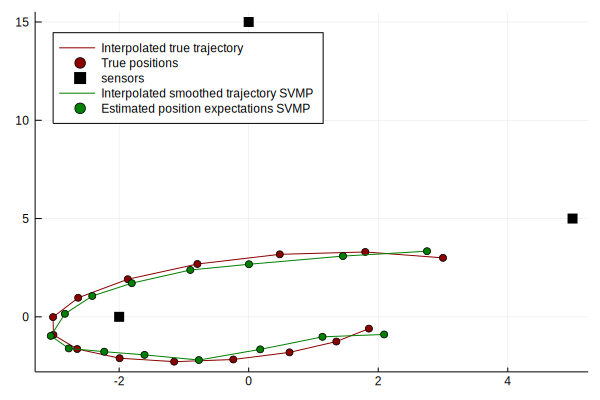

In [23]:
smooth_plot = zeros(2,T)
for t=1:T
    smooth_plot[:,t] = mean(q_z_marg[t])[1:2]
end
plot(position[1,:],position[2,:],color=:redsblues,legend=:topright, label="Interpolated true trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="True positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")
plot!(smooth_plot[1,:],smooth_plot[2,:],color=:green,legend=:topleft, label="Interpolated smoothed trajectory SVMP")
plot!(smooth_plot[1,:],smooth_plot[2,:], seriestype = :scatter,color=:green, label="Estimated position expectations SVMP")

In [24]:
writedlm("SVMP_FE_x.txt", SVMP_FE_x)
writedlm("SVMP_FE_y.txt", SVMP_FE_y)
writedlm("SVMP_q_z_mean.txt", smooth_plot)

In [26]:
@show smooth_plot;

smooth_plot = [2.75302 1.45549 0.00390832 -0.901242 -1.80542 -2.41531 -2.83798 -3.05563 -2.77745 -2.23031 -1.6084 -0.76948 0.177925 1.13891 2.09088; 3.33867 3.09068 2.67516 2.38368 1.71166 1.0606 0.153865 -0.969873 -1.60779 -1.77397 -1.93557 -2.1981 -1.65575 -1.01767 -0.897263]


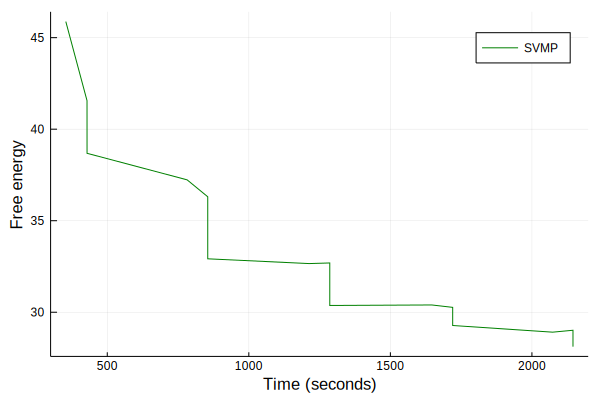

In [27]:
# Plot free energy over time
plot(SVMP_FE_x, SVMP_FE_y, color=:green, label="SVMP", xlabel = "Time (seconds)", ylabel = "Free energy")